# Land Classifcaton Algorithms
An evaluation of land classification algorthims using various machine learning techniques. Comparing time and space efficiency, accuracy to known software results, and conducting statistical tests. 

## 1. Introduction

Satellite remote sensing of the earth is an effective way to gather data over a large surface area. This data can be used for various assessments, such as determining the vegetative health of  a region, the richness of the soil, or the composition of the landscape. Land classification models discern which areas within a scene belong to which land cover type; such as, coniferous vegetation, deciduous vegetation, wetlands, water bodies, urban areas, agriculture, grasslands, or desert. This can then be used for land development, natural resource management, and impact assessment studies [1]. These land classification algorithms help to turn satellite imagery into a tangible product which can then be compared to other data. As sensors become more spectrally and spatially refined, more accurate and detailed accounts for land cover are possible. Geographers are starting to take a ‘hands off’ approach to analyses and trust in computing power to derive their products. Machine learning and artificial intelligence is emerging as a large player in perfecting models for geography analyses. This study will compare probabilistic, support vector machine, and neural network models. As there are many avenues which have been explored, and many different models to compare to, this project will start with a broad scope and become more focused with time. 


In [1]:
# Bring in required libraries
import numpy as np
#import cv2
import matplotlib.pyplot as plt

# Import gdal
from osgeo import gdal
import time

# Import machine learning algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit, StratifiedKFold

## 2. Data and Methods
### 2.1 Data
The study area is the southern tip of Vancouver Island which includes the city of Victoria and the Saanich Penninsula (Fig. 1). It was chosen because it has a heterogenous landscape and very little snow cover. 
- Take more info from the proposal description and literature 

[From Proposal]Considerations when procuring data for this project will be temporal and spatial resolution of the data. Data from the summer months will have a larger variety of vegetation than data from the winter months and finer spatial resolution will allow for more detailed and accurate classification because there will be less pixel mixing. Multiple data sources may be considered so long as they are open and available.

[From Proposal]The study area is the Saanich Peninsula which has a complex and heterogeneous landscape. It contains various agriculture, urban, and water based landscapes which will lead to a more difficult and interesting classification. The data displayed below is available through the U.S Geological Survey, and was gathered using the Sentinel-2A platform [2,3]. The tile gathered using the Sentinel-2 was acquired on November 11, 2018 on a descending orbit. The spatial resolution of this product is 10, 20, or 60 meters depending on which spectral bands are being considered. The latitude and longitude of the centre of the tile is 48°15’27.01”N and 123°36’29.39”W respectively. As the study area will consist of only the Saanich Peninsula this tile will be trimmed before processing. 

The data came from the European Space Agency and was collected using the Sentinel 2A mission delivered as a level 1C product.
- talk about the type of sensor what it is commonly used for and why it was chosen 


The bands being considered for the land classification are bands 1 through 10, bands 11 and 12 are removed from consideration as they are typically used for atmospheric correction. As the 10m resolution data is quite large it will subset to a slightly more narrow view.

Table 1: Sentinel 2A Spectral Bands and Resolution where NIR is near infrared, MIR is mid infrared, VNIR is vegetation near infrared (red edge spectral domain), and SWIR is short wave infrared.

|Band Number|Type  |Central Wavelength (nm)|Bandwidth (nm)|Resolution (m)|
|-----------|------|-----------------------|--------------|--------------|
|   1       |Violet| 442.7                 | 27           | 60           |
|   2       |Blue  | 492.4                 | 98           | 10           |
|   3       |Green | 599.8                 | 45           | 10           |
|   4       |Red   | 664.6                 | 38           | 10           |
|   5       |VNIR  | 704.5                 | 19           | 20           |
|   6       |VNIR  | 740.5                 | 18           | 20           |
|   7       |VNIR  | 782.8                 | 28           | 20           |
|   8       |NIR   | 832.8                 | 145          | 10           |
|   8a      |VNIR  | 864.7                 | 33           | 20           |
|   9       |MIR   | 442.7                 | 27           | 60           |
|   10      |MIR   | 442.7                 | 27           | 60           |
|   11      |SWIR  | 1613.7                | 143          | 20           |
|   12      |SWIR  | 2202.4                | 242          | 20           |


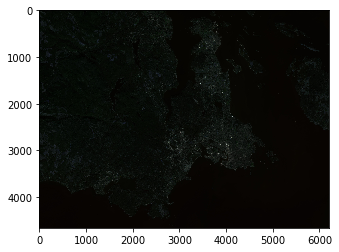

In [2]:
#load and display the data

# Set paths to GeoTiff and figures
tif_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\S2A_0928\\'
fig_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\Figures\\'

# Open GeoTiff file
dataset = gdal.Open(tif_path+'S2A_0928_MLE_whole.tif', gdal.GA_ReadOnly)

# Display RGB image with bands 4,3,2 respectively
options_list = ['-ot Byte','-of JPEG', '-b 2', '-b 3', '-b 4', '-scale'] 
options_string = " ".join(options_list)

gdal.Translate(tif_path+'study_area.jpg', tif_path+'S2A_0928_MLE_whole.tif', options=options_string)
img = plt.imread(tif_path+'study_area.jpg')
plt.figure(1)
plt.imshow(img)

# Display study area with enhancement
# !!! TODO


In [3]:
# Save each band from dataset in a 3D array
S2_array = np.zeros((1,1,1))
#print('Descriptive statistics for each band')
stats_all = np.empty([4])
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = band.ReadAsArray()
    if x <= 1:
        S2_array = np.array(array)
    else:
        S2_array = np.dstack((S2_array, np.array(array)))
   
    # Print statistics for each band
    stats = band.GetStatistics(True,True)
    stats_all = np.vstack((stats_all,stats))
    #print("Band #%d: Minimum=%.3f, Maximum=%.3f, Mean=%.3f, Standard Deviation=%.3f"%(x,stats[0],stats[1],
                                                                                      #stats[2],stats[3]))
data_bands = dataset.RasterCount
num_bands = data_bands - 2
print('Shape of Dataset')
print(S2_array.shape)
print('Number of bands')
print(data_bands)

# Subset the dataset to be slightly smaller shaving off 600 pixels from 
# the left and right sides and 100 from the top and bottom
#S2_array = S2_array[100:4557,1800:5405,:]

Shape of Dataset
(4657, 6205, 13)
Number of bands
13


The training data include 7 classes: [1 2 3 4 5 6 7]
Class ID 1: Urban
Class ID 2: Forest
Class ID 3: Shrub
Class ID 4: Agriculture
Class ID 5: Grassland
Class ID 6: Wetland
Class ID 7: Water


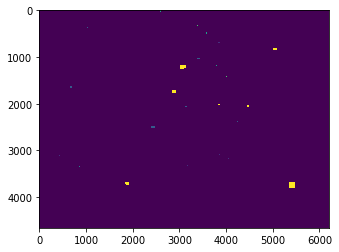

In [4]:
# Extract classification labels from dataset
#!!!CHANGE COLOURS AND SIZE
sites = S2_array[:,:,11]
S2_image = S2_array[:,:,0:11]
MLE_image = S2_array[:,:,12]
l,w = sites.shape
labels_ID,counts = np.unique(sites[sites>0], return_counts = True)
print('The training data include %d classes: %s'%(labels_ID.size, labels_ID))

# Create dictionary for each class
class_labels = {1:'Urban',2:'Forest',3:'Shrub',4:'Agriculture',5:'Grassland',6:'Wetland',7:'Water'}
for i in labels_ID:
    print('Class ID %d: %s'%(i,class_labels[i]))

# Display training sites
plt.imshow(sites)

### 2.2 Classification Methods
#### 2.2.1 Process data and create base classification for comparison
The data was delivered as a level 1C product which means that system processing has been completed. The dataset contains top of the atmosphere returns which require an atmospheric correction. 
- Explain what an atmospheric correction is and why it is required

Prior to preforming a land classificaton the data was resampled to 10m using bilinear resampling, then a subset was chosen for the study area.

- Explain the PCI software and why it will be used as the base case classification model, how it works, etc.


#### 2.2.2 Recreate Maximum Likelihood Classification
Using a Gaussian distribution.

#### 2.2.3 Support Vector Machine
- What is a support vector machine

There are various types: linear, polynomial, and rbf.
- explain the differences

The different types of kernels for the SVM was analyzed for accuracy and one chosen to compare to the PCI software output.

#### 2.2.4 Neural Network
One node for each band plus the x and y location.
Consider the multilayer perceptron.

#### 2.2.5 Time and Space Efficiency
Each machine learning algorithm tested was timed to determine the time effeciency. The space effiecency for each algorthm will also be analyzed.

#### 2.2.6 Accuracy Assessment 
There are various accuracy tests that were conducted. The first is a built in accuracy score determined with the scikit learn library score() function which takes in a test set of training sites where the classification is known and compares them to the algorithm's actual output. The number of training pixels set aside for testing was 400 and they were determined with random selection. 

The second accuracy test conducted was a confusion matrix.
- explain indepth

Also include the following accuracy tests with in depth descriptions:

#### 2.2.7 Statistical Comparison to base
The pixel by pixel differece was compared and then a root mean square error and r-square value were determined for each scene.
- explain why and what thesea are

The number of correcly classified pixels will be divided by the the total number of pixels to gather a percentage of correctly classified pixels. As the PCI classification output may not be 100% if these values are >70% that will be considered good.

## 3. Results
### 3.1 Data Preparation and Descriptive Statistics
Descriptive statistics for each spectral band from the dataset

In [5]:
# Print descriptive statistics for each band
numB = 0
for numB in range(0,12):
    print("Band #%d: Minimum=%.3f, Maximum=%.3f, Mean=%.3f, Standard Deviation=%.3f"%(numB+1,stats_all[numB,0],
                                                                                      stats_all[numB,1], 
                                                                                      stats_all[numB,2],
                                                                                      stats_all[numB,3]))
    numB += 1

Band #1: Minimum=0.000, Maximum=0.000, Mean=339.743, Standard Deviation=252.817
Band #2: Minimum=1008.000, Maximum=2573.000, Mean=1160.923, Standard Deviation=78.239
Band #3: Minimum=656.000, Maximum=6087.000, Mean=832.732, Standard Deviation=111.000
Band #4: Minimum=393.000, Maximum=5761.000, Mean=597.282, Standard Deviation=158.194
Band #5: Minimum=198.000, Maximum=7323.000, Mean=365.727, Standard Deviation=197.341
Band #6: Minimum=157.000, Maximum=6220.000, Mean=483.101, Standard Deviation=301.141
Band #7: Minimum=121.000, Maximum=6526.000, Mean=978.969, Standard Deviation=790.413
Band #8: Minimum=119.000, Maximum=6788.000, Mean=1169.910, Standard Deviation=1002.647
Band #9: Minimum=86.000, Maximum=7795.000, Mean=1122.960, Standard Deviation=1021.890
Band #10: Minimum=71.000, Maximum=7501.000, Mean=1284.588, Standard Deviation=1155.643
Band #11: Minimum=29.000, Maximum=1701.000, Mean=303.167, Standard Deviation=252.365
Band #12: Minimum=1.000, Maximum=21.000, Mean=5.583, Standard De

Prepare the data by creating a table for the sample data then sperating into training set, testing set, and image classification set.

The table was prepared in order to resolve 3D array issues and the (X,Y) coordinates of each pixel are attached to each row as geography/proximity play a roll in the classification.
- will back this claim or change the sample table

In [6]:
# Prepare the sample table adding the (x,y) coordinates
sample_size = 0

# Add the locational x,y fields to consider geography
sample_table = np.empty([num_bands+3], int)

# Count the total number of sample pixels, number for each class
# And create an array for each class for samples from band 2 (BLUE)
# Will have to add arrays for each band being considered
for i in range(l):
    for j in range(w):   
        cl = sites[i,j]
        if cl >0:
            sample_size += 1
            t_row, add_cor = S2_image[i,j,0:num_bands], np.array([i,j])
            cor_t_row = np.concatenate((t_row,add_cor),axis=None)
            class_t_row = np.concatenate((cor_t_row,cl),axis=None)
            sample_table = np.dstack((sample_table, class_t_row)) 
                
print('The number of training pixels are: %d'%(sample_size))
print('The total number of pixels is: %d'%(l*w))
print('The number of urban pixels is: %d'%(counts[0]))
print('The number of forest pixels is: %d'%(counts[1]))
print('The number of shrub pixels is: %d'%(counts[2]))
print('The number of agriculture pixels is: %d'%(counts[3]))
print('The number of grassland pixels is: %d'%(counts[4]))
print('The number of wetland pixels is: %d'%(counts[5]))
print('The number of water pixels is: %d'%(counts[6]))

The number of training pixels are: 63281
The total number of pixels is: 28896685
The number of urban pixels is: 2758
The number of forest pixels is: 9015
The number of shrub pixels is: 676
The number of agriculture pixels is: 3003
The number of grassland pixels is: 1303
The number of wetland pixels is: 298
The number of water pixels is: 46228


Divide the samples into train and test split at 33% which comes from research. Then at 50% to see if a larger test set would prevent accuracy overestimation [2].
- Would like to preform cross-validation next.

In [7]:
# Extract Y_train and X_train from table
sample_table2 = sample_table[0,:,:]
ln, wd = sample_table2.shape
X = np.array(sample_table2[0:ln-1,:].T,int)
Y = np.array(sample_table2[ln-1:ln,:],int)
Y = Y[0,:]

X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.50)

print('Testing and training set:')
print(X_test.shape)
#print(X_test[0:5])
print(X_train.shape)
#print(X_train[0:5])
print(Y_test.shape)
#print(Y_test[0:5])
print(Y_train.shape)
#print(Y_train[0:5])

# Extract classification data from GeoTiff array and create matrix
temp = S2_image[:,:,0]
XX,YY = np.meshgrid(np.arange(temp.shape[1]),np.arange(temp.shape[0]))
corX = XX.ravel()
corY = YY.ravel()
cor = np.vstack((corX,corY)).T
temp2 = S2_image.reshape(l*w,num_bands)

print('Image to be Classified:')
image_class = np.zeros([l*w,num_bands+2],int)
image_class[:,:11] = temp2
image_class[:,11:] = cor
print(image_class.shape)
#print(image_class[0:5])

Testing and training set:
(31641, 13)
(31641, 13)
(31641,)
(31641,)
Image to be Classified:
(28896685, 13)


The 10m resolusion GeoTiff is massive and requires segmentation in order to run the prediction models using scikit-learn. If this is not done then memory is depleted, and results require hours of time.

In [8]:
# Divide data into to 4 for faster processing
datLen,fields = image_class.shape 
qt = int(datLen/4)
image_classAa = image_class[:qt,:]
image_classAb = image_class[qt:qt*2,:]
image_classBa = image_class[qt*2:qt*3,:]
image_classBb = image_class[qt*3:,:]

### 3.2 PCI Software Output
The accuracy assesment completed using the PCI software will be output here as well.

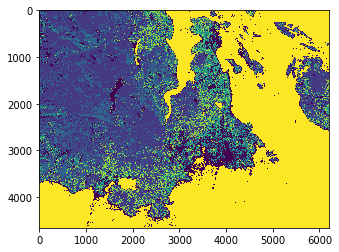

In [9]:
# Maximum likelihood classifier created by PCI software
plt.imshow(MLE_image)

## 3.3 Maximum Likelihood Classification
Using the gaussian distribution for MLE and default paramters is good, will continue to refine this and reduce the gap between the PCI output and this.

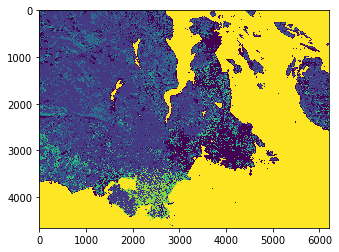

In [10]:
# Maximum Likelihood Classifier from Scikit - learn (using numpy by hand was causing issues)

#!!! LOOK INTO WEIGHTING AND OTHER IMPLEMENTATIONS

mle_start = time.time()

mle = GaussianNB()

# Fit the classifier on the training dataset
mle.fit(X_train, Y_train)

mle_fit_t = time.time()

# Predict the classification for each pixel in image
mle_Y_predAa = mle.predict(image_classAa)
mle_Y_predAb = mle.predict(image_classAb)
mle_Y_predBa = mle.predict(image_classBa)
mle_Y_predBb = mle.predict(image_classBb)

mle_pred_t = time.time()

# Check shape of output and reshape to display image
mle_Y_whole = np.append(mle_Y_predAa,mle_Y_predAb)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBa)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBb)
mle_img = mle_Y_whole.reshape(l,w)

# Print the score using the test set data
mle_score = mle.score(X_test,Y_test)

plt.imshow(mle_img)

In [11]:
# Calculate time efficiency for MLE
print('The time it took to fit the classification model with the training data: %.6f seconds'%(mle_fit_t-mle_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(mle_pred_t-mle_fit_t))
print('The time it took to run the classification method: %.6f seconds'%(mle_pred_t-mle_start))
print('The number of classes in this image: %s'%(np.unique(mle_Y_whole)))

The time it took to fit the classification model with the training data: 0.509042 seconds
The time it took to predict the image classification matrix: 78.837881 seconds
The time it took to run the classification method: 79.346923 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


## 3.3 Support Vector Machine
Trying different kernel types, and regularization parameter (C):
LINEAR kernel works well with C = 0.3.
RBF kernel does not work at all (just continues running for over an hour even after assigning max_iter). Will attempt to change parameters to correct this as research shows it is a common kernel type for land classification models [2].
POLYNOMIAL kernels work well, but wish to improve based on order and regularization parameter.
Moving forward in the accuracy assessment LINEAR kernel is currently being used as a comparison.

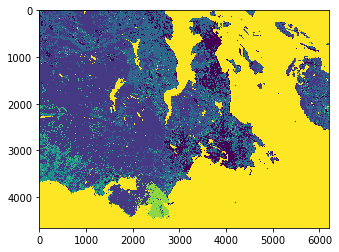

In [12]:
# SVC - support vector classification
# LINEAR Kernel Test
svc_start = time.time()

svc = svm.SVC(kernel = 'linear', C = .3) 

# Fit the classifier on the training dataset
svc.fit(X_train, Y_train)

svc_fit_t = time.time()

# Predict the classification for each pixel in image
svc_Y_predAa = svc.predict(image_classAa)
svc_Y_predAb = svc.predict(image_classAb)
svc_Y_predBa = svc.predict(image_classBa)
svc_Y_predBb = svc.predict(image_classBb)

svc_pred_t = time.time()

# Check shape of output and reshape to display image
svc_Y_whole = np.append(svc_Y_predAa,svc_Y_predAb)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBa)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBb)
svc_img = svc_Y_whole.reshape(l,w)

# Print the score using the test set data
svc_score = svc.score(X_test,Y_test)

plt.imshow(svc_img)

In [13]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(svc_fit_t-svc_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(svc_pred_t-svc_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(svc_pred_t-svc_start))
print('The number of classes in this image: %s'%(np.unique(svc_Y_whole)))

The time it took to fit the SVC classification model with the training data: 29.339978 seconds
The time it took to predict the image classification matrix: 248.060952 seconds
The time it took to run the SVC classification method: 277.400930 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [ ]:
# Try different models and print output
C = .3 # regularization parameter - try varying these values

svc_start = time.time()

# Fit the classifier on the training dataset
clf_rbf = svm.SVC(kernel="rbf", C=C, max_iter = 100)
clf_rbf.fit(X_train,Y_train)

svc_fit_t = time.time()

# Predict the classification for each pixel in image
rbf_Y_predAa = clf_rbf.predict(image_classAa)
rbf_Y_predAb = clf_rbf.predict(image_classAb)
rbf_Y_predBa = clf_rbf.predict(image_classBa)
rbf_Y_predBb = clf_rbf.predict(image_classBb)

svc_pred_t = time.time()

score_rbf = clf_rbf.score(X_test, Y_test)

# Check shape of output and reshape to display image
rbf_Y_whole = np.append(rbf_Y_predAa,rbf_Y_predAb)
rbf_Y_whole = np.append(rbf_Y_whole,rbf_Y_predBa)
rbf_Y_whole = np.append(rbf_Y_whole,rbf_Y_predBb)

rbf_img = rbf_Y_whole.reshape(l,w)
poly_score = clf_rbf.score(X_test,Y_test)

plt.figure(1)
plt.imshow(rbf_img)

In [ ]:
print('the SVC RFB method accuracy score %.6f'%(score_rfb))
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(svc_fit_t-svc_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(svc_pred_t-svc_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(svc_pred_t-svc_start))

print('The number of classes in this image: %s'%(np.unique(rbf_Y_whole)))

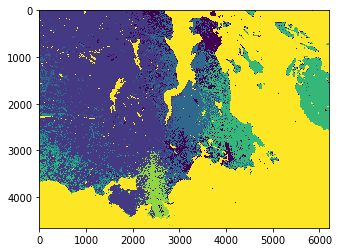

In [17]:
C = .3 # regularization parameter - try varying these values
gamma = 5

poly_start_t = time.time()

poly = svm.SVC(kernel="poly", gamma=gamma, degree=3, C=C)

poly.fit(X_train, Y_train)

poly_fit_t = time.time()

# Predict the classification for each pixel in image
poly_Y_predAa = poly.predict(image_classAa)
poly_Y_predAb = poly.predict(image_classAb)
poly_Y_predBa = poly.predict(image_classBa)
poly_Y_predBb = poly.predict(image_classBb)

poly_pred_t = time.time()

# Check shape of output and reshape to display image
poly_Y_whole = np.append(poly_Y_predAa,poly_Y_predAb)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBa)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBb)
poly_img = poly_Y_whole.reshape(l,w)

# Print the score using the test set data
poly_score = poly.score(X_test,Y_test)

plt.imshow(poly_img)

In [20]:
print('the SVC 3rd Order Polynomial method accuracy score %.6f'%(poly_score))

# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(poly_fit_t-poly_start_t))
print('The time it took to predict the image classification matrix: %.6f seconds'%(poly_pred_t-poly_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(poly_pred_t-poly_start_t))

print('The number of classes in this image: %s'%(np.unique(poly_Y_whole)))

the SVC 3rd Order Polynomial method accuracy score 0.999810
The time it took to fit the SVC classification model with the training data: 0.517089 seconds
The time it took to predict the image classification matrix: 184.478122 seconds
The time it took to run the SVC classification method: 184.995211 seconds
The number of classes in this image: [1 2 3 4 5 6 7]



## 3.4 Neural Network
Trying different number of nodes within a single hidden layer with tanh activation based on research [3]:
- trial and error for number of nodes:
    - 14 underestimates the number of classes
    - 20 good overestimates shrub/urban
    - 25 97% overestimates water
    - 23 98% overestimates water
    - 24 97% overestimates shrub/urban
Try different activations to improve accuracy.

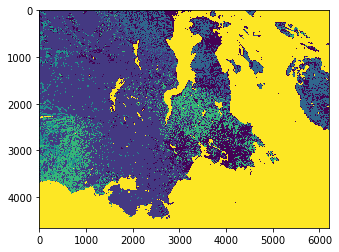

In [21]:
# Neural Network from scikit - learn

nn_start = time.time()

nn = MLPClassifier(hidden_layer_sizes=(23,), activation='tanh')

# Fit the classifier on the training dataset
nn.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nn.predict(image_classAa)
nn_Y_predAb = nn.predict(image_classAb)
nn_Y_predBa = nn.predict(image_classBa)
nn_Y_predBb = nn.predict(image_classBb)

nn_pred_t = time.time()

nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nn_img = nn_Y_whole.reshape(l,w)

nn_score = nn.score(X_test,Y_test)

plt.imshow(nn_img)

In [22]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nn_Y_whole)))

The time it took to fit the NN classification model with the training data: 5.718444 seconds
The time it took to predict the image classification matrix: 29.474393 seconds
The time it took to run the NN classification method: 35.192837 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


## 3.5 Time and Space Complexity
Need to calculate still


## 3.6 Accuracy Assessment


- A confusion matrix will be used to compare each label and it's accuracy against misclassifications. 

- The precision and recall will be considered for each algorithm with an overall F-Measure and Accuracy Measure.

- The statistical difference between each algorithm's error rate within a given confidence interval (90% or 95%)

These determinants along with the time and space efficiency will be considered. A weighting of each determinate could be applied to give each algorithm a quantitative score. This has yet to be determined but may look something like:

0.70 * accuracy + 0.15 time efficiency + 0.15 space efficiency = algorithm score

As there are many other factors to consider beyond this scoring method it will aid in a final decision but each algorithm will be looked at in depth. For example, to determine which algorithm may classify one land type better than another.


The accuracy score below was derived from the built in scoring function which is part of the scikit-learn library for each machine learning algorithm.

In [23]:
# Score function from scikit learn output based on X_test and Y_test data
print('MLE accuracy function score: %.6f'%(mle_score))
print('SVC accuracy function score: %.6f'%(svc_score))
print('NN accuracy function score: %.6f'%(nn_score))

MLE accuracy function score: 0.984356
SVC accuracy function score: 0.998578
NN accuracy function score: 0.980500


The accuracy score below is used to determine each algorithms accuracy against the ground truth layer:
accuracy = # correct predictions/ # instances

In [24]:
# Consider the accuracy calculation {accuracy = # correct predictions / # instances}
cor_mle, cor_svc, cor_nn = 0,0,0
for i in range(l):
    for j in range(w):   
        cl = sites[i,j]
        if cl>0:
            if mle_img[i,j] == cl:
                cor_mle += 1
            if svc_img[i,j] == cl:
                cor_svc += 1
            if nn_img[i,j] == cl:
                cor_nn += 1
acc_mle = cor_mle/sample_size
acc_svc = cor_svc/sample_size
acc_nn = cor_nn/sample_size

print('MLE accuracy score: %.6f'%(acc_mle))
print('SVC accuracy score: %.6f'%(acc_svc))
print('NN accuracy score: %.6f'%(acc_nn))

MLE accuracy score: 0.965061
SVC accuracy score: 0.917858
NN accuracy score: 0.854143


Maximum Likelihood Estimation
[[ 1424     0     0     0     0     0     0     0]
 [    0  4422   122     0     0     7     0     0]
 [    0     8   297     0    18     8     0     0]
 [  249     0     0  1256    11     0     0     0]
 [   19     0     0    42   557     0     0     0]
 [    0     1     0     0     9   135     0     0]
 [    0     0     0     0     0     0 23055     0]
 [    1     0     0     0     0     0     0     0]]

Support Vector Classification - Linear
[[ 1424     0     0     0     0     0     0     0]
 [    0  4551     0     0     0     0     0     0]
 [    0     0   330     0     1     0     0     0]
 [    1     0     0  1496    19     0     0     0]
 [    0     0     1    22   595     0     0     0]
 [    0     0     0     0     0   145     0     0]
 [    0     0     0     0     0     0 23055     0]
 [    0     1     0     0     0     0     0     0]]

Multi-Layer Perceptron
[[ 1303     0     0   120     1     0     0     0]
 [    0  4538     0     0    13     0

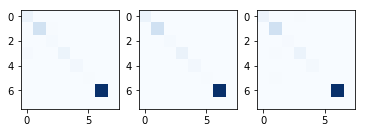

In [25]:
# Calculate the confusion matrix for each classification method and display side by side
mle_test = mle.predict(X_test)
svc_test = svc.predict(X_test)
nn_test = nn.predict(X_test)

# MLE confusion matrix
mle_con_mx = confusion_matrix(Y_test, mle_test)

# SVC confusion matrix
svc_con_mx = confusion_matrix(Y_test, svc_test)

# Neural network confusion matrix
nn_con_mx = confusion_matrix(Y_test, nn_test)

print('Maximum Likelihood Estimation')
print(mle_con_mx)
print()
    
i=1
plt.subplot(1, 3, i)
plt.imshow(mle_con_mx, cmap="Blues")

print('Support Vector Classification - Linear')
print(svc_con_mx)
print()
    
plt.subplot(1, 3, i+1)
plt.imshow(svc_con_mx, cmap="Blues")

print('Multi-Layer Perceptron')
print(nn_con_mx)
print()
    
plt.subplot(1, 3, i+2)
plt.imshow(nn_con_mx, cmap="Blues")

In [27]:
# Consider the F-Measure, recall, and precision
#try different averaging methods (do more research)
p_mle, r_mle, f_mle, s_mle = precision_recall_fscore_support(Y_test,mle_test,average='macro')
p_mle,r_mle,f_mle = p_mle.round(decimals = 6),r_mle.round(decimals = 6),f_mle.round(decimals = 6)
p_svc, r_svc, f_svc, s_svc = precision_recall_fscore_support(Y_test,svc_test,average='macro')
p_svc,r_svc,f_svc = p_svc.round(decimals = 6),r_svc.round(decimals = 6),f_svc.round(decimals = 6)
p_nn, r_nn, f_nn, s_nn = precision_recall_fscore_support(Y_test,nn_test,average='macro')
p_nn,r_nn,f_nn = p_nn.round(decimals = 6),r_nn.round(decimals = 6),f_nn.round(decimals = 6)
print('MLE Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_mle,r_mle,f_mle))
print('SVC Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_svc,r_svc,f_svc))
print('NN Classifier - precision, recall, and F-Measure for each class')
print('%s\n%s\n%s\n'%(p_nn,r_nn,f_nn))

MLE Classifier - precision, recall, and F-Measure for each class
0.793961
0.81622
0.802082

SVC Classifier - precision, recall, and F-Measure for each class
0.868631
0.868321
0.868475

NN Classifier - precision, recall, and F-Measure for each class
0.717995
0.676074
0.694416



C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Cross validation
# from https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

# MLE with cross validation
shuffle = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scoring = ['precision_macro','recall_macro']
scores_all = {}
kf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, Y):
    scores = cross_validate(mle, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_all = merge_two_dicts(scores_all, scores)
#print(scores_all)
#print(scores.keys())
#print(scores['fit_time'])
#print(scores['score_time'])
#print(scores['test_precision_macro'])
#print(scores['train_precision_macro'])
#print(scores['test_recall_macro'])
#print(scores['train_recall_macro'])

In [ ]:
# Final quantitative value for each method
# Consider including the F-measure, recall, or precision as well
# 0.70 * accuracy + 0.15 time efficiency + 0.15 space efficiency = algorithm score

## 3.6 Comparison to PCI Maximum Likelihood Estimation


Comparison between PCI MLE and scikit-learn MLE
The rmse between PCI MLE and scikit-learn MLE is: 1.355557
The r-square between PCI MLE and scikit-learn MLE is: 0.535667


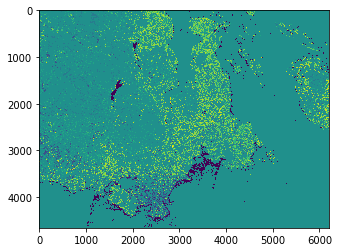

In [28]:
from sklearn.metrics import r2_score
print('Comparison between PCI MLE and scikit-learn MLE')
# Calculate rmse
mle_diff = MLE_image - mle_img
plt.imshow(mle_diff)

sse = np.sum([x**2 for x in mle_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn MLE is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, mle_img)
print('The r-square between PCI MLE and scikit-learn MLE is: %.6f'%(r2))

Comparison between PCI MLE and scikit-learn SVC
The rmse between PCI MLE and scikit-learn SVC is: 1.497463
The r-square between PCI MLE and scikit-learn SVC is: 0.414997


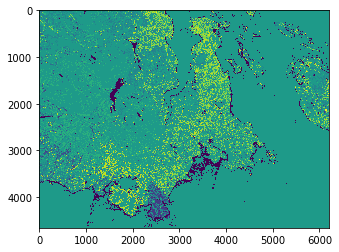

In [29]:
print('Comparison between PCI MLE and scikit-learn SVC')
# Calculate rmse
svc_diff = MLE_image - svc_img
plt.imshow(svc_diff)

sse = np.sum([x**2 for x in svc_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn SVC is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, svc_img)
print('The r-square between PCI MLE and scikit-learn SVC is: %.6f'%(r2))

Comparison between PCI MLE and scikit-learn Neural Network
The rmse between PCI MLE and scikit-learn Neural Network is: 1.635869
The r-square between PCI MLE and scikit-learn Neural Network is: 0.311123


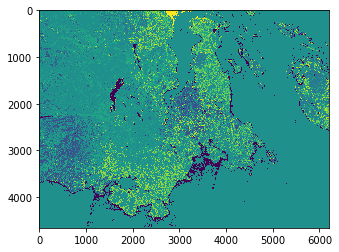

In [30]:
print('Comparison between PCI MLE and scikit-learn Neural Network')
# Calculate rmse
nn_diff=MLE_image - nn_img
plt.imshow(nn_diff)

sse = np.sum([x**2 for x in nn_diff])
rmse = np.sqrt((sse)/(l*w)) 
print('The rmse between PCI MLE and scikit-learn Neural Network is: %.6f'%(rmse))

# Calculate r-square
r2 = r2_score(MLE_image, nn_img)
print('The r-square between PCI MLE and scikit-learn Neural Network is: %.6f'%(r2))

## 4. Discussion


## 5. References

[1] Noi, P.T. and Kappa, M., 2018: Comparison of Random Forest, k-Nearest Neighbor, and Support Vector Machine Classifiers for 
    Land Cover Classification Using Sentinel-2 Imagery, Sensors. DOI: 10.3390/s18010018

[2] J. He, J.R. Harris, M. Sawada & P. Behnia (2015) A comparison of classification algorithms using Landsat-7 and Landsat-8 
    data for mapping lithology in Canada’s Arctic, International Journal of Remote Sensing, 36:8, 2252-2276, DOI: 
    10.1080/01431161.2015.1035410 

[3] F. Sunar Erbek , C. Özkan & M. Taberner (2004) Comparison of maximum likelihood classification method with supervised 
    artificial neural network algorithms for land use activities , International Journal of Remote Sensing, 25:9, 1733-1748, 
    DOI: 10.1080/0143116031000150077 